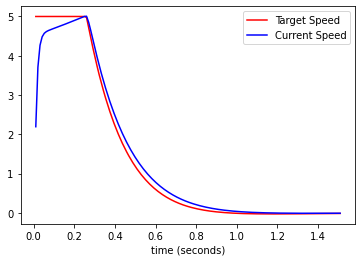

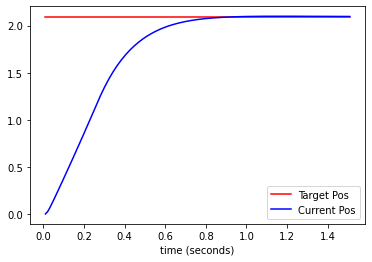

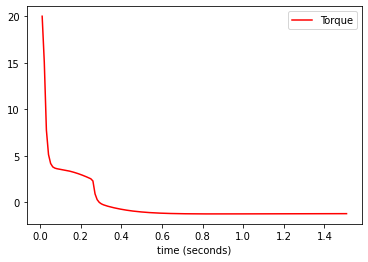

In [3]:
import sys
sys.path.append("../../")

from lib.data.dataplot import *
from lib.system.basic import *
from lib.system.controllers import *
from lib.system.arm import *
from lib.dds.dds import *
from lib.utils.time import *

class PositionSpeedControl:
    
    def __init__(self, kp_pos, sat_pos, 
                         kp_speed, ki_speed, sat_speed):
        self.position_controller = P_Controller(kp_pos, sat_pos)
        self.speed_controller = PI_Controller(kp_speed, ki_speed, sat_speed)
        self.target_pos = 0
        self.target_speed = 0
        
    def set_target_position(self, p):
        self.target_pos = p
        
    def evaluate(self, delta_t, current_pos, current_speed):
        pos_error = self.target_pos - current_pos
        self.target_speed = self.position_controller.evaluate(delta_t, pos_error)
        
        speed_error = self.target_speed - current_speed
        out = self.speed_controller.evaluate(delta_t, speed_error)
        return out
        

pos_dp = DataPlotter()
pos_dp.set_x("time (seconds)")
pos_dp.add_y("target", "Target Pos")
pos_dp.add_y("current", "Current Pos")

spd_dp = DataPlotter()
spd_dp.set_x("time (seconds)")
spd_dp.add_y("target", "Target Speed")
spd_dp.add_y("current", "Current Speed")

f_dp = DataPlotter()
f_dp.set_x("time (seconds)")
f_dp.add_y("torque", "Torque")

dds = DDS()
dds.start()

arm = Arm(1.0, 0.5, 0.9)
# mass = 1 Kg
# length = 0.5 meters
# friction = 0.9

ctrl = PositionSpeedControl(5.0, 5.0,     # kp = 5, sat = 5 rad/s
                            5.0, 20.0, 20.0) # kp =5, ki = 10, sat = 20 Nm


t = Time()
t.start()

current_speed = arm.omega
current_pos = arm.theta

ctrl.set_target_position(math.radians(120))

while t.get() < 1.5:
    
    t.sleep(0.01)
    delta_t = t.elapsed()
    
    torque = ctrl.evaluate(delta_t, current_pos, current_speed)
    (current_pos, current_speed) = arm.evaluate(delta_t, torque)
    
    dds.publish('theta', current_pos, DDS.DDS_TYPE_FLOAT)
    
    spd_dp.append_x(t.get())
    spd_dp.append_y("target", ctrl.target_speed)
    spd_dp.append_y("current", current_speed)
    
    pos_dp.append_x(t.get())
    pos_dp.append_y("target", ctrl.target_pos)
    pos_dp.append_y("current", current_pos)
    
    f_dp.append_x(t.get())
    f_dp.append_y("torque", torque)
    
spd_dp.plot()
pos_dp.plot()
f_dp.plot()

dds.stop()
